# Time series data, InfluxDB, and Milvus

The purpose of this notebook is to highlight how to convert your time series data into vectors to be inserted in a vector database like Milvus. 

Imaginary Use Case: Imagine you're developing a platform that offers real-time traffic monitoring and pattern recognition to improve city traffic management. Specifically, you want to create a solution that identifies when traffic conditions are operating anomalously and determine the type traffic anomaly that is present like an accident, traffic, or construction. fluxDB would store the time-series data from the sensors, while Milvus would store the image data and manage the search indices for complex queries. In this scenario you could continuously monitor traffic data like average speed and vehicle count in InfluxDB. You might also be collecting traffic image data in Zilliz. When your traffic conditions fall outside of norm, you send this anomalous traffic data to Milvus. Then you perform a similarity search in Milvus to identify what type of anomaly it is. 


# 1. Import Dependencies 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
# plotting
import matplotlib.pyplot as plt
# milvus client library
from pymilvus import FieldSchema, CollectionSchema, DataType

# 2. Define Function to generate some Traffic Data 

In [2]:
def generate_sensor_data(anomaly_type, speed_limit, vehicle_count_range, avg_speed_range, rows=500):
    """
    Generate a DataFrame with sensor data including vehicle count, avg speed, anomaly type, and timestamp.
    
    Parameters:
    - anomaly_type: string, the type of traffic anomaly (traffic, accident, road work)
    - vehicle_count_range: tuple, the range (min, max) of vehicle count
    - avg_speed_range: tuple, the range (min, max) of average speed
    - rows: int, number of rows to generate
    
    Returns:
    - df: pandas DataFrame
    """
    # Generate data
    np.random.seed(42)  # For reproducible results
    vehicle_counts = np.random.randint(vehicle_count_range[0], vehicle_count_range[1], size=rows)
    avg_speeds = np.random.uniform(avg_speed_range[0], avg_speed_range[1], size=rows)
        
    # Generate timestamps
    start_time = datetime.now()
    timestamps = [start_time + timedelta(seconds=5*i) for i in range(rows)]
    
    # Create DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'Vehicle Count': vehicle_counts,
        'Average Speed': avg_speeds,
        'Anomaly Type': anomaly_type,
        'Speed Limit': speed_limit
    })
    
    return df

# Example usage
vehicle_count_range = (20, 40)  # Configure the min and max vehicle count here
avg_speed_range = (20.0, 45.0)  # Configure the min and max average speed here
df = generate_sensor_data("accident", 45, vehicle_count_range, avg_speed_range)

# Display the DataFrame
df.head()  # Showing the first 5 rows for brevity

,Timestamp,Vehicle Count,Average Speed,Anomaly Type,Speed Limit
0,2024-03-20 23:38:04.702217,26,44.216299,accident,45
1,2024-03-20 23:38:09.702217,39,37.200750,accident,45
2,2024-03-20 23:38:14.702217,34,40.924097,accident,45
3,2024-03-20 23:38:19.702217,30,41.671718,accident,45
4,2024-03-20 23:38:24.702217,27,40.962019,accident,45


# 3. Explore the Data


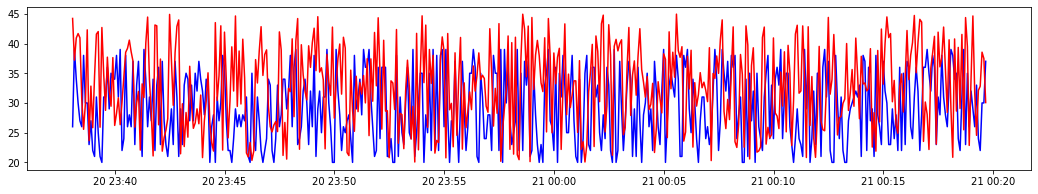

In [3]:
# Plot time series for each sensor with BROKEN state marked with X in red color
plt.figure(figsize=(18, 3))
plt.plot(df["Timestamp"], df["Vehicle Count"], color="blue")
plt.plot(df["Timestamp"], df["Average Speed"], color="red")
plt.show()

# 4. Create Sensor Vector Embeddings


### Group The Average Speed Values into Time Windows


In [4]:
# Set the window size (number of rows in each window)
window_size = 24
step_size = 10

In [5]:
# define windows
windows = [
    df.iloc[i : i + window_size]
    for i in range(0, len(df) - window_size + 1, step_size)
]

In [6]:
# Iterate through the windows & extract column values
start_times = [w["Timestamp"].iloc[0] for w in windows]
end_times = [w["Timestamp"].iloc[-1] for w in windows]
avg_speed_values = [w["Average Speed"].tolist() for w in windows]
vehicle_count_values = [w["Vehicle Count"].tolist() for w in windows]
anomaly_type = [w["Anomaly Type"].iloc[0] for w in windows]

In [7]:
# Create a new DataFrame from the collected data
embedding_df = pd.DataFrame(
    {"start_time": start_times, "end_time": end_times, "vectors": avg_speed_values, "anomaly_type": anomaly_type}
)

In [8]:
embedding_df.head()

,start_time,end_time,vectors,anomaly_type
0,2024-03-20 23:38:04.702217,2024-03-20 23:39:59.702217,"[44.21629859935337, 37.200750254375976, 40.924...",accident
1,2024-03-20 23:38:54.702217,2024-03-20 23:40:49.702217,"[32.833154217309826, 25.830701810613196, 34.53...",accident
2,2024-03-20 23:39:44.702217,2024-03-20 23:41:39.702217,"[32.041674699102884, 29.44968975305636, 37.627...",accident
3,2024-03-20 23:40:34.702217,2024-03-20 23:42:29.702217,"[39.179871327714295, 40.56975879691733, 38.605...",accident
4,2024-03-20 23:41:24.702217,2024-03-20 23:43:19.702217,"[40.05273122566835, 44.447516718856775, 33.900...",accident


# 5. Normalize These Sensor Value Windows


In [9]:
# Function to normalize the sensor column
def normalize_vector(vectors: list) -> list:
    min_val = min(vectors)
    max_val = max(vectors)
    return (
        [0.0] * len(vectors)
        if max_val == min_val
        else [(v - min_val) / (max_val - min_val) for v in vectors]
    )

In [10]:
embedding_df["vectors"] = embedding_df["vectors"].apply(normalize_vector)

In [11]:
embedding_df.head()

,start_time,end_time,vectors,anomaly_type
0,2024-03-20 23:38:04.702217,2024-03-20 23:39:59.702217,"[1.0, 0.6586303556175065, 0.8398047190151606, ...",accident
1,2024-03-20 23:38:54.702217,2024-03-20 23:40:49.702217,"[0.4152889075137363, 0.0, 0.5160786959257689, ...",accident
2,2024-03-20 23:39:44.702217,2024-03-20 23:41:39.702217,"[0.44555475043951626, 0.329713057632252, 0.695...",accident
3,2024-03-20 23:40:34.702217,2024-03-20 23:42:29.702217,"[0.7599441640096685, 0.8183163952785817, 0.735...",accident
4,2024-03-20 23:41:24.702217,2024-03-20 23:43:19.702217,"[0.7966023690497857, 0.9811737396606427, 0.538...",accident


## Convert the timestamps to unix time

In [12]:
# Apply a lambda function to convert timestamps to Unix timestamp format
embedding_df['start_time'] = embedding_df['start_time'].apply(lambda x: pd.Timestamp(x).timestamp()).astype(int)
embedding_df['end_time'] = embedding_df['end_time'].apply(lambda x: pd.Timestamp(x).timestamp()).astype(int)

In [13]:
embedding_df.head()

,start_time,end_time,vectors,anomaly_type
0,1710977884,1710977999,"[1.0, 0.6586303556175065, 0.8398047190151606, ...",accident
1,1710977934,1710978049,"[0.4152889075137363, 0.0, 0.5160786959257689, ...",accident
2,1710977984,1710978099,"[0.44555475043951626, 0.329713057632252, 0.695...",accident
3,1710978034,1710978149,"[0.7599441640096685, 0.8183163952785817, 0.735...",accident
4,1710978084,1710978199,"[0.7966023690497857, 0.9811737396606427, 0.538...",accident


In [14]:
# convert embedding_df into an entity in preperation for write to Zilliz
entity = [embedding_df[col].tolist() if col != 'vectors' else embedding_df[col].values.tolist() for col in embedding_df.columns]

In [15]:
# Data to insert from DataFrame into Milvus
data_to_insert = [
    {"vector_field": v, "start_time_field": start, "stop_time_field": stop, "anomaly_type_field": anomaly_type}
    for v, start, stop, anomaly_type in zip(embedding_df["vectors"], embedding_df["start_time"], embedding_df["end_time"], embedding_df["anomaly_type"])
]
# Including output of the data_to_insert or entities to understand the dictionary structure. 
data_to_insert[1]

{'vector_field': [0.4152889075137363,
  0.0,
  0.5160786959257689,
  0.9339400228588051,
  0.9594734908121221,
  0.005125718915339806,
  1.0,
  0.5317701130450202,
  0.1734560938192518,
  0.7041917323428484,
  0.3683492576103222,
  0.2146284560942277,
  0.6996001992375626,
  0.022975347039706807,
  0.14385381806643827,
  0.29834547817214996,
  0.03032638050008518,
  0.25497817191418676,
  0.5015006484653414,
  0.7528119491160616,
  0.7916886403499066,
  0.8741175973964925,
  0.7576124843394686,
  0.6639498473288101],
 'start_time_field': 1710977934,
 'stop_time_field': 1710978049,
 'anomaly_type_field': 'accident'}

# 6. Store Entities in Zillis 


In [16]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

import pandas as pd

# Establish a connection to Milvus server (adjust host and port as necessary)
connections.connect("default", host="127.0.0.1", port="19530")

In [17]:
# Define the schema for your collection
pk = FieldSchema(name="pk", dtype=DataType.INT64, is_primary=True, auto_id=True)
vector_field = FieldSchema(name="vector_field", dtype=DataType.FLOAT_VECTOR, dim=24)
start_time_field = FieldSchema(name="start_time_field", dtype=DataType.INT64)
stop_time_field = FieldSchema(name="stop_time_field", dtype=DataType.INT64)
anomaly_type_field = FieldSchema(name="anomaly_type_field", dtype=DataType.VARCHAR, max_length=100)

# Create a collection schema
schema = CollectionSchema(fields=[pk, vector_field, start_time_field, stop_time_field, anomaly_type_field], description="test collection")

# Define your collection name
collection_name = "example_collection"

# Fix: Correctly check if the collection exists
if not utility.has_collection(collection_name):
    collection = Collection(name=collection_name, schema=schema)
    print(f"Collection {collection_name} created.")
else:
    collection = Collection(name=collection_name)
    print(f"Collection {collection_name} already exists.")

# Insert the data into Milvus
insert_result = collection.insert(data_to_insert)
print("Insertion is successful, IDs assigned to the inserted entities:", insert_result.primary_keys)

# Create an index for better search performance 
index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "L2",
    "params": {"nlist": 128}
}
collection.create_index(field_name="vector_field", index_params=index_params)
print("Index created.")

# Load the collection into memory (before searching)
collection.load()

Collection example_collection created.
Insertion is successful, IDs assigned to the inserted entities: [448176745802109136, 448176745802109137, 448176745802109138, 448176745802109139, 448176745802109140, 448176745802109141, 448176745802109142, 448176745802109143, 448176745802109144, 448176745802109145, 448176745802109146, 448176745802109147, 448176745802109148, 448176745802109149, 448176745802109150, 448176745802109151, 448176745802109152, 448176745802109153, 448176745802109154, 448176745802109155, 448176745802109156, 448176745802109157, 448176745802109158, 448176745802109159, 448176745802109160, 448176745802109161, 448176745802109162, 448176745802109163, 448176745802109164, 448176745802109165, 448176745802109166, 448176745802109167, 448176745802109168, 448176745802109169, 448176745802109170, 448176745802109171, 448176745802109172, 448176745802109173, 448176745802109174, 448176745802109175, 448176745802109176, 448176745802109177, 448176745802109178, 448176745802109179, 4481767458021091

In [18]:
# List all collections to verify successful creation
existing_collections = utility.list_collections()
print(existing_collections)

['example_collection']


# 7. Perform a Similarity Search

Euclidean Distance (L2): Suitable for time series of the same length and when the time series are aligned in time and scale. It may not be effective if the series are out of phase or if there's variability in the speed of patterns across the series.

In [19]:
# Prepare for search

vectors_to_search = [data_to_insert[1]["vector_field"]]  # Using the second vector for search
search_params = {
    "metric_type": "L2",
    "params": {"L2": 10},
}

result = collection.search(vectors_to_search, "vector_field", search_params, limit=3, output_fields=["vector_field", "anomaly_type_field"])

ids = []
# Display search results
for hits in result:
    for hit in hits:
        ids.append(hit.id)
        print(f"ID: {hit.id}, Distance: {hit.distance}")

ID: 448176745802109137, Distance: 0.0
ID: 448176745802109177, Distance: 2.9583234786987305
ID: 448176745802109166, Distance: 3.0145297050476074


In [20]:
# List of IDs for which you want to retrieve vectors
ids_to_retrieve = ids  # Example IDs

# Constructing a query expression to match these IDs
# Note: The "pk" field is assumed to be the primary key field based on your schema definition
query_expression = f'pk in {ids_to_retrieve}'

# Specify the fields you want to retrieve, in this case, the vector field
fields_to_retrieve = ["vector_field"]

# Perform the query to retrieve the vectors
results = collection.query(expr=query_expression, output_fields=fields_to_retrieve)

# Display the retrieved vectors
for result in results:
    print(f"ID: {result['pk']}, Vector: {result['vector_field']}")

ID: 448176745802109137, Vector: [0.4152889, 0.0, 0.5160787, 0.93394, 0.9594735, 0.005125719, 1.0, 0.5317701, 0.17345609, 0.70419174, 0.36834925, 0.21462846, 0.6996002, 0.022975348, 0.14385381, 0.29834548, 0.030326381, 0.25497818, 0.50150067, 0.75281197, 0.7916886, 0.8741176, 0.75761247, 0.66394985]
ID: 448176745802109166, Vector: [0.90165377, 0.14239085, 0.20097858, 0.6741652, 1.0, 0.2966756, 0.620136, 0.7326777, 0.4580456, 0.7692905, 0.9902541, 0.66268575, 0.56245303, 0.44234994, 0.60727364, 0.3432325, 0.3861684, 0.5530342, 0.0, 0.19305421, 0.5661003, 0.43377155, 0.31643105, 0.7892212]
ID: 448176745802109177, Vector: [0.04504527, 0.035670184, 0.4180506, 1.0, 0.3470277, 0.47130913, 0.8547435, 0.44320112, 0.0, 0.14553934, 0.15861139, 0.2690697, 0.30632365, 0.77782315, 0.20848012, 0.35871154, 0.5568514, 0.2443033, 0.8243202, 0.50941944, 0.13852204, 0.6694612, 0.433819, 0.44242516]


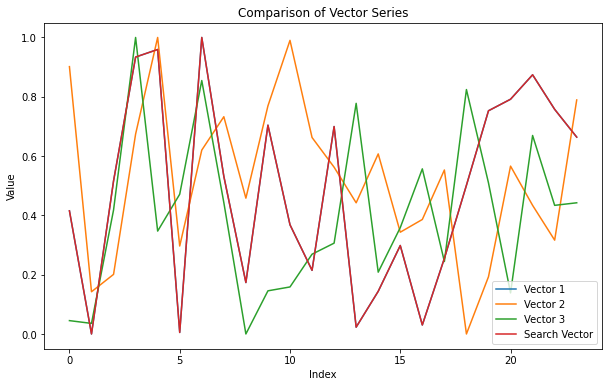

In [21]:
data_to_plot = [{'Vectors': item['vector_field']} for item in results]

plt.figure(figsize=(10, 6))

# Plot each vector as a separate line
for i, entry in enumerate(data_to_plot):
    plt.plot(entry['Vectors'], label=f'Vector {i+1}')

plt.plot(vectors_to_search[0], label=f'Search Vector')    
# Adding plot title, and labels for x and y axes
plt.title('Comparison of Vector Series')
plt.xlabel('Index')
plt.ylabel('Value')

# Adding a legend to distinguish each line
plt.legend()

# Show the plot
plt.show()

Notice how Vector 1 and Search Vector overlap because the vector with the smallest difference will be the same vector. 

# 8. Perform MAE (mean absolute error) to quantify the similarity

Note that within this context the MAE doesn't hold much meaning. This is because we generated random data. In a real world example you would be comparing time series data that represent an event and that follow a general pattern or behavior. You would also be searching across a lot more data. 

In [22]:
# Calculate MAE
mae = np.mean(np.abs(np.array(vectors_to_search[0]) - np.array(data_to_plot[1]["Vectors"])))
print(f"MAE: {mae}")
# A MAE of 0.3 indicates moderate to high dissimilarity which is expected for random data. 

MAE: 0.3145208857923114


# Delete all collections and disconnect 

In [23]:
# Delete all collections
for collection_name in existing_collections:
    # Load the collection
    collection = Collection(name=collection_name)
    # Drop the collection
    collection.drop()
    print(f"Deleted collection: {collection_name}")

# Don't forget to disconnect
connections.disconnect("default")

Deleted collection: example_collection
